# Лабораторная работа №1 "Проведение исследований с алгоритмом KNN"

## Подключение вспомогательных библиотек

In [26]:
import math

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.model_selection
import sklearn.neighbors
import sklearn.preprocessing
import sklearn.metrics

import collections

## Классификация

### 1. Выбор начальных условий

#### Выбор датасета

Перед началом обучения моделей для решения задачи классификации необходимо в первую очередь выбрать датасет.

В качестве датасета я выбрал [Banking Customer Churn Prediction Dataset](https://www.kaggle.com/datasets/saurabhbadole/bank-customer-churn-prediction-dataset) с Kaggle, который содержит информацию о клиентах банка, а также состояние оттока пользователей.

Итого, задача классификация здесь будет использована для определения, уйдет ли клиент от банка или нет, на основе информации о нем.

Такой датасет может быть применен, например, для решения задач банка при оценке долгосрочной ценности клиента на основе информации о нем, использовании продуктов, позволяя сосредоточить ресурсы компании на более прибыльных клиентах.

In [3]:
!kaggle datasets download -q -p dataset -d saurabhbadole/bank-customer-churn-prediction-dataset
!unzip dataset/bank-customer-churn-prediction-dataset.zip -d dataset/

Dataset URL: https://www.kaggle.com/datasets/saurabhbadole/bank-customer-churn-prediction-dataset
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
Archive:  dataset/bank-customer-churn-prediction-dataset.zip
  inflating: dataset/Churn_Modelling.csv  


После скачивания датасета загрузим его в память и провизуализируем его краткое содержание

In [52]:
ds = pd.read_csv("dataset/Churn_Modelling.csv")
ds.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#### Выбор метрик

Для задачи классификации важно использовать метрики, которые будут отображать производительность модели с учетом особенностей данных, как, к примеру, несбалансированность данных.

Итого, были выбраны следующие метрики для оценки обученной модели для решения задачи классификации:

- **Accuracy** - эта метрика самая распространенная и дает общее представление о доле правильно классифицированных объектов. Она хорошо подходит для поверхностной оценки модели, однако не является достаточно информативной при наличии особенностей в датасете, таких как несбалансированность.

- **Precision** - данная метрика показывает, на сколько модель уверена в своих предсказаниях для класса **уходящих** клиентов. Такая метрика важна в случаях, когда мы заинтересованы в минимизации ложных срабатываний. Проецируя на доменную область решаемой задачи, это может помочь банку не тратить лишние ресурсы на удержание клиентов, которые в итоге не планируют уходить.

- **Recall** - данная метрика показывает, на сколько хорошо модель обнаруживает всех **уходящих** клиентов. В случае с банками, данная метрика помочь не упустить клиентов, котоыре в итоге покинут банк.

- **F1-Score** - данная метрика представляет собой гармоническое среднее между Precision и Recall. Она является особенно полезной при наличии особенностей в данных, таких как несбалансированность. Сама метрика учитывает как ложные срабатывания, так и пропущенные случаи.

Итого, использование перечисленного набора метрик поможет нам получить более точную оценку обученной модели и удостовериться, что при несбалансированности данных модель не будет просто выбирать самый частый класс.


### 2. Создание бейзлайна и оценка качества

Перейдем к формированию бейзлайна. Сама задача бейзлайна состоит в создании простой начальной версии модели, которая будет выполнять роль отправной точки для дальнейших улучшений бейзлайна.

С этой целью выполним минимальное преобразование датасета, чтобы он был пригоден для обучения модели. Как видно по краткой визуализации выше, в датасете присутствуют категориальные признаки, которые однако представлены в виде строк. Такой формат не пригоден для оубчения модели, поэтому воспользуемся one-hot encoding для преобразования их в набор численных признаков.

In [57]:
baseline_ds = ds.drop(columns=["RowNumber", "CustomerId", "Surname"])

baseline_ds = pd.get_dummies(baseline_ds, columns=["Geography"], dtype=int)
baseline_ds = pd.get_dummies(baseline_ds, columns=["Gender"], dtype=int)

baseline_ds.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


Перейдем теперь к этому обучения модели. Для этого создадим вспомогательные функции:

- `generate_train_data` - отвечает за то, чтобы сгенерировать набор данных для тестирования и обучения на основе переданного датасета

- `get_model_metrics` - отвечает за рассчет показаний метрик для уже обученной модели на основе тестовых данных

- `print_model_metrics` - отвечает за отформатированный вывод показаний метрик

In [54]:
def generate_train_data(dataset, *, target_feature="Exited", random_state=42, test_size=0.2):
  X = dataset.drop(columns=[target_feature])
  y = dataset[target_feature]

  X_train, X_test, y_train, y_test = map(
    np.array,
    sklearn.model_selection.train_test_split(
      X, y,
      test_size=test_size,
      random_state=random_state,
    ),
  )

  return (X_train, y_train), (X_test, y_test)


def get_model_metrics(model, X_test, y_test):
  y_pred = model.predict(X_test)

  accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
  precision = sklearn.metrics.precision_score(y_test, y_pred)
  recall = sklearn.metrics.recall_score(y_test, y_pred)
  f1 = sklearn.metrics.f1_score(y_test, y_pred)

  confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)

  return {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "confusion_matrix": confusion_matrix,
  }

def print_model_metrics(model, X_test, y_test):
  metrics = get_model_metrics(model, X_test, y_test)

  print(f"Accuracy: {metrics['accuracy']:.4f}")
  print(f"Precision: {metrics['precision']:.4f}")
  print(f"Recall: {metrics['recall']:.4f}")
  print(f"F1-Score: {metrics['f1']:.4f}")

  print("\nConfusion Matrix:")
  print(metrics["confusion_matrix"])


Обучим теперь модель KNN для решения задачи классификации на бейзлайн-датасете, который мы ранее определили и выведем на экран показатели метрик для итоговой обученной модели.

In [55]:
(X_train, y_train), (X_test, y_test) = generate_train_data(baseline_ds)

model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=4)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Accuracy: 0.7855
Precision: 0.2500
Recall: 0.0458
F1-Score: 0.0774

Confusion Matrix:
[[1553   54]
 [ 375   18]]


#### Выводы

На основе полученных показателях метрик можно сделать вывод о том, что на первый взгляд может показаться, что модель достаточно хорошо справляется с поставленной задачей, если смотреть на метрику "Accuracy".

Однако, если брать во внимание показатели метрик "Precision" и "Recall", значения которых слишком маленькие, то мы можем сделать вывод о том, что модель не учитывает несбалансированность данных.

Также, если посмотреть на показатели метрики "F1-Score", то мы убеждаемся в слабом балансе между классами, и что модель плохо справляется с выявлением уходящих клиентов.


### 3. Улучшение бейзлайна

### Масштабирование данных

Известно, что алгоритм KNN очень чувствителен к масштабу значение, так как они представляют координаты, на основе которых позже считается значение метрики расстояния.

И так, проверим, различаются ли диапазоны данных для признаков в датасете.

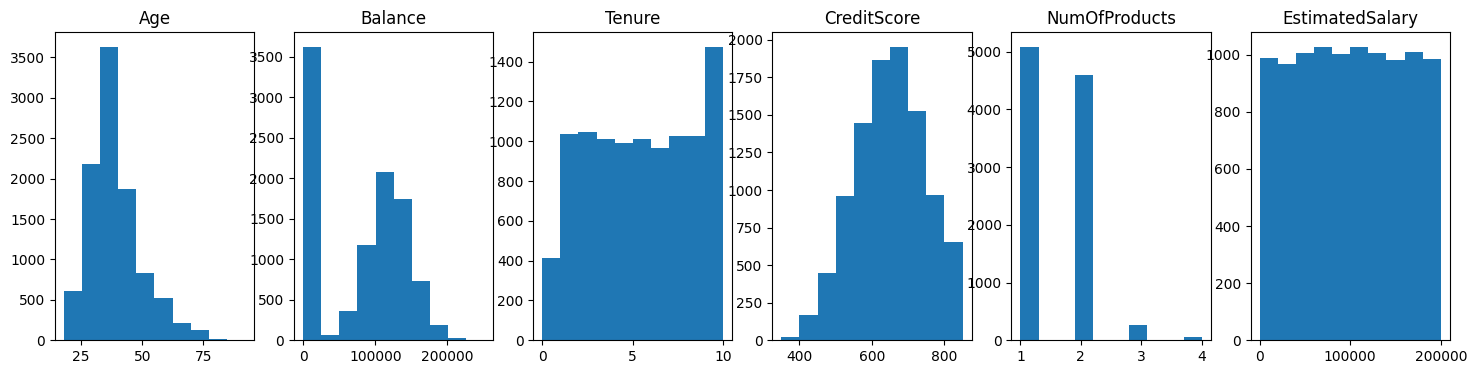

In [59]:
numerical_features = [ "Age", "Balance", "Tenure", "CreditScore", "NumOfProducts", "EstimatedSalary" ]
n = len(numerical_features)


plt.figure(figsize=(18, 4))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, n, i)
    plt.hist(ds[feature])
    plt.title(feature)

plt.show()

Как видим, диапазоны значений для признаков сильно различаются, из-за чего неявно может оказаться, что один признак будет иметь больший вес по сравнению с другим, хотя значения этих весов не обоснованы.

Попробуем решить найденную проблему путем нормализации значений, тем самым приведя диапазоны значений к единому.

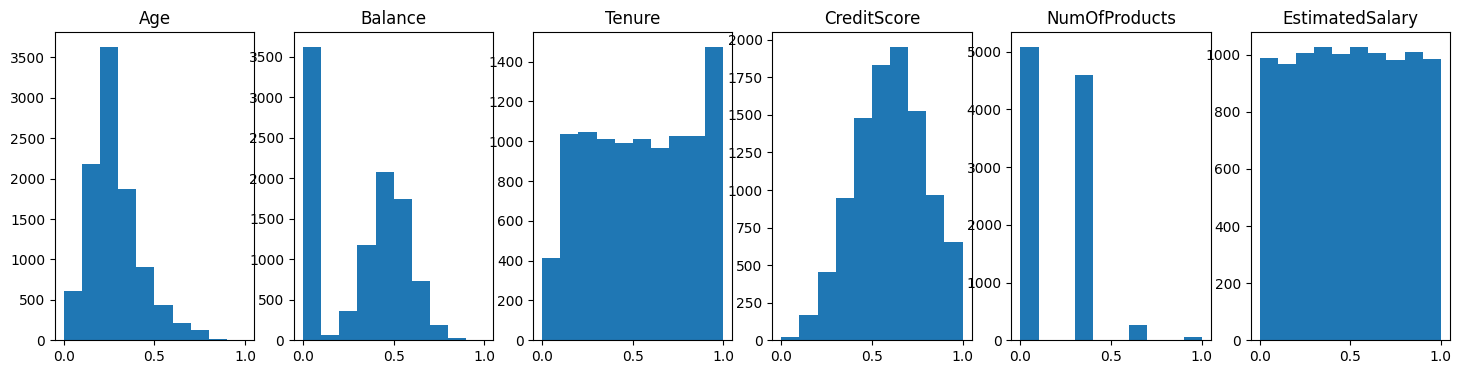

In [60]:
scaler = sklearn.preprocessing.MinMaxScaler()
optimized_ds = baseline_ds.copy()
optimized_ds[numerical_features] = scaler.fit_transform(optimized_ds[numerical_features])


plt.figure(figsize=(18, 4))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, n, i)
    plt.hist(optimized_ds[feature])
    plt.title(feature)

plt.show()

Проверим, улучшились ли показатели метрик после произведенных улучшений бейзлайна

In [61]:
(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds)

model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=4)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Accuracy: 0.8260
Precision: 0.6619
Recall: 0.2341
F1-Score: 0.3459

Confusion Matrix:
[[1560   47]
 [ 301   92]]


Как видим, показатели метрик действительно улучшились, а следовательно гипотеза оказалась верной.

#### Подбор гиперпараметров

Иногда значения гиперпараметров, установленные в модели по умолчанию, не всегда являются оптимальными для конкретного датасета.

Поэтому, иногда имеет смысл подобрать более оптимальные значения гиперпараетров, которые больше подходить для текущего датасета.

Попробуем подобрать такие значения гиперпараметров на основе алгоритма grid search.

In [20]:
param_grid = {
  "n_neighbors": [2, 3, 5, 7, 9, 12],
  "weights": ["uniform", "distance"],
  "metric": ["euclidean", "manhattan"],
}


(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds)
model = sklearn.neighbors.KNeighborsClassifier()
grid = sklearn.model_selection.GridSearchCV(model, param_grid, scoring="f1", cv=5)
grid.fit(X_train, y_train)

results = grid.cv_results_
best_score = grid.best_score_

# Вывод результатов

best_params = grid.best_params_
best_model = grid.best_estimator_

grid.fit(X_train, y_train)

print(f"Best Parameters: {best_params}")
print_model_metrics(grid, X_test, y_test)



Best Parameters: {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'}
Accuracy: 0.7935
Precision: 0.4727
Recall: 0.4402
F1-Score: 0.4559

Confusion Matrix:
[[1414  193]
 [ 220  173]]


Как видим, значение метрики "Accuracy" немного уменьшилось, однако эти жертвы оправданы значительным улучшением показателей метрики "F1-Score"!

Модель стала более устойчивой к несбалансированности данных. Также, необычным оказалось то, что большое количество принимаемых во внимание "соседей" не играла на руку. Более оптимальным оказалось меньшее значение!

### 4. Имплементация алгоритма машинного обучения

Перейдем теперь к собственной имплементации алгоритма KNN для решения задачи классификации. Решение я реализовал в виде класса `MyKNNClassifier`, который имеет интерфейс, схожий с тем, что используется в библиотеке `sklearn`. присутствуют 2 метода: `fit` - для обучения модели, `predict` - для предсказания классов для уже обученной модели.

Определение метрики расстояния я решил реализовать через функции, которые принимают на вход два массива объектов и считает попарно расстояние между ними.

In [62]:
def _broad_casted(f):
  def wrapper(ax, bx):
    return np.array([[f(a, b) for b in bx] for a in ax])  # TODO: optimize
  return wrapper


@_broad_casted
def cosine_distance(a, b):
  dot_product = np.dot(a, b)
  norm_1 = np.sqrt(np.sum(a ** 2, axis=-1))
  norm_2 = np.sqrt(np.sum(b ** 2, axis=-1))
  return 1.0 - dot_product / (norm_1 * norm_2)


@_broad_casted
def euclidean_distance(a, b):
  return np.sqrt(np.sum((a - b) ** 2, axis=-1))


@_broad_casted
def manhattan_distance(a, b):
  return np.sum(np.abs(a - b), axis=-1)

In [63]:
class MyKNNClassifier:
  def __init__(self, k_neighbors=3, metric=euclidean_distance):
    self.__k = k_neighbors
    self.__distance = metric

    self.__x = None
    self.__y = None

  def fit(self, X, y):
    self.__x = np.array(X, dtype=float)
    self.__y = np.array(y, dtype=int)

  def predict(self, X):
    X = np.array(X, dtype=float)
    distances = self.__distance(self.__x, X).T
    neighbors_ids = np.argsort(distances, axis=-1)

    neighbors_classes = self.__y[neighbors_ids[:, :self.__k]]
    predicted_classes = np.array([
      collections.Counter(row).most_common(1)[0][0]
      for row in neighbors_classes
    ])

    return predicted_classes

#### Сравнение с бейзлайном

Обучим теперь реализованную модель на датасете, соответствущем бейзлайну. Из-за определенных ранее вспомогательных функций и схожего интерфейса класса модели основной алгоритм обучения не меняется.



In [66]:
(X_train, y_train), (X_test, y_test) = generate_train_data(baseline_ds)

model = MyKNNClassifier(k_neighbors=4)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Accuracy: 0.7370
Precision: 0.2096
Recall: 0.1221
F1-Score: 0.1543

Confusion Matrix:
[[1426  181]
 [ 345   48]]


Сравним полученные результаты для имплементированной модели с результатами из пункта 2.

Показатели метрик "Accuracy" и "Precision" оказались незначительно, но все же меньше, по сравнению с моделью из пункта 2. Вероятно, это связано с неполной поддержкой всех параметров для настройки модели, которые потенциально могли бы улучшить показатели модели.

Однако, показатели метрики "F1-Score" оказались примерно в 2 раза выше, чем у модели из пункта 2. Это говорит о том, что имплементированная модель лучше справляется с несбалансированностью данных.

#### Сравнение с улучшенным бейзлайном

In [65]:
(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds)
model = MyKNNClassifier(k_neighbors=2, metric=euclidean_distance)
model.fit(X_train, y_train)
print_model_metrics(model, X_test, y_test)

Accuracy: 0.7935
Precision: 0.4727
Recall: 0.4402
F1-Score: 0.4559

Confusion Matrix:
[[1414  193]
 [ 220  173]]


Иная ситуация происходит при обучении модели на улучшенном бейзлайне. Теперь, показатели метрик стали очень близки к тем, что показала модель из пункта 3, что говорит о том, что найденные значения гиперпараметров `k_neighbors` и `metric` внесли самый большой вклад в улучшение модели.

## Регрессия

### Выбор начальных условий

#### Выбор датасета

Перед началом обучения моделей для решения задачи регрессии необходимо в первую очередь выбрать датасет.

В качестве датасета я выбрал [Taxi Price Regression](https://www.kaggle.com/datasets/denkuznetz/taxi-price-prediction) с Kaggle, который содержит информацию о стоимости поездок на такси на основе различных факторов, таких как расстояние, время суток, дорожные условия и многое другое.

Итого, задача регрессии здесь будет использована для определения стоимости поездки на основе ее параметров и условий, в которых она будет совершена.

Такой датасет может быть применен на практике со стороны компаний для оптимизации ценообразования в службах такси. Например, для создания системы, которая автоматически определяет оптимальную стоимость поездки на основе динамических факторов, таких как время суток, спрос, погодные условия и т. д.

In [27]:
!kaggle datasets download -q -p dataset -d denkuznetz/taxi-price-prediction
!unzip dataset/taxi-price-prediction.zip -d dataset/

Dataset URL: https://www.kaggle.com/datasets/denkuznetz/taxi-price-prediction
License(s): apache-2.0
Archive:  dataset/taxi-price-prediction.zip
  inflating: dataset/taxi_trip_pricing.csv  


После скачивания датасета загрузим его в память и провизуализируем его краткое содержание

In [67]:
ds = pd.read_csv("/content/dataset/taxi_trip_pricing.csv")
ds.head()

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.35,Morning,Weekday,3.0,Low,Clear,3.56,0.80,0.32,53.82,36.2624
1,47.59,Afternoon,Weekday,1.0,High,Clear,NaN,0.62,0.43,40.57,NaN
2,36.87,Evening,Weekend,1.0,High,Clear,2.70,1.21,0.15,37.27,52.9032
3,30.33,Evening,Weekday,4.0,Low,NaN,3.48,0.51,0.15,116.81,36.4698
4,NaN,Evening,Weekday,3.0,High,Clear,2.93,0.63,0.32,22.64,15.6180


#### Выбор метрик

Для задачи регрессии были выбраны следующие метрики:

- **MAE** - данная метрика дает прямую интерпретацию ошибки в тех же единицах, что и целевая переменная. В нашем случае данная метрика будет показывать, на сколько в денижных единицах будет ошибаться модель между предсказанной и реальной стоимостью поездки. Это позволит оценить ошибки модели с финансовой точки зрения.

- **R-squared** - данная метрика показывается, какая доля дисперсии целевой переменной обьясняется моделью. Она поможет определить, на сколько хорошо модель обьясняет данные, присутствуют ли в датасете важные данные, на сколько сама модель хорошо подогнана к данным.


### 2. Создание бейзлайна и оценка качества

Перейдем к формированию бейзлайна. Сама задача бейзлайна состоит в создании простой начальной версии модели, которая будет выполнять роль отправной точки для дальнейших улучшений бейзлайна.

С этой целью выполним минимальное преобразование датасета, чтобы он был пригоден для обучения модели. Для начала проверим, существуют ли записи в датасете с пропущенными данными.

In [68]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trip_Distance_km       950 non-null    float64
 1   Time_of_Day            950 non-null    object 
 2   Day_of_Week            950 non-null    object 
 3   Passenger_Count        950 non-null    float64
 4   Traffic_Conditions     950 non-null    object 
 5   Weather                950 non-null    object 
 6   Base_Fare              950 non-null    float64
 7   Per_Km_Rate            950 non-null    float64
 8   Per_Minute_Rate        950 non-null    float64
 9   Trip_Duration_Minutes  950 non-null    float64
 10  Trip_Price             951 non-null    float64
dtypes: float64(7), object(4)
memory usage: 86.1+ KB


Как видим, датасет содержит пропущенные датасеты в каждом из признаков, включая и целевую переменную - стоимость поездки. Также, стоит отметить, что некоторые признаки в датасете являются категориальными, а некоторые - численными.

Итого, предлагается выполнить следующую обработку датасета:

- убрать записи, в которых пропущены цены на поездку, так как в этом и состоит основная задача модели. А генерировать данные (такие как медианное значение) не имеет смысла и может только испортить итоговую модель, так как она может предсказывать неправильную цену на поездку.

- для категориальных признаков оставим пропущенные значения, так как в этом случае, в ходе one-hot encoding они будут просто преобразованы в наборы нулей: `[0, ..., 0]`

- для численных признаков заменим пропущенные значения на медианное значение

In [70]:
baseline_ds = ds.dropna(subset=["Trip_Price"])

numeric_features = [
  "Trip_Distance_km",
  "Passenger_Count",
  "Base_Fare",
  "Per_Km_Rate",
  "Per_Minute_Rate",
  "Trip_Duration_Minutes",
]
baseline_ds[numeric_features] = baseline_ds[numeric_features].apply(lambda col: col.fillna(col.median()))

categorical_features = [
  "Time_of_Day",
  "Day_of_Week",
  "Traffic_Conditions",
  "Weather",
]

for feature in categorical_features:
  encoded_feature = pd.get_dummies(baseline_ds[feature], prefix=feature, dtype=int)
  baseline_ds[encoded_feature.columns] = encoded_feature
  baseline_ds = baseline_ds.drop(columns=[feature])

baseline_ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 951 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Trip_Distance_km           951 non-null    float64
 1   Passenger_Count            951 non-null    float64
 2   Base_Fare                  951 non-null    float64
 3   Per_Km_Rate                951 non-null    float64
 4   Per_Minute_Rate            951 non-null    float64
 5   Trip_Duration_Minutes      951 non-null    float64
 6   Trip_Price                 951 non-null    float64
 7   Time_of_Day_Afternoon      951 non-null    int64  
 8   Time_of_Day_Evening        951 non-null    int64  
 9   Time_of_Day_Morning        951 non-null    int64  
 10  Time_of_Day_Night          951 non-null    int64  
 11  Day_of_Week_Weekday        951 non-null    int64  
 12  Day_of_Week_Weekend        951 non-null    int64  
 13  Traffic_Conditions_High    951 non-null    int64  
 14 

Перейдем теперь к этапу обучения модели. Аналогично с частью решения задачи классификации, создадим вспомогательные функции:

- `generate_train_data` - отвечает за то, чтобы сгенерировать набор данных для тестирования и обучения на основе переданного датасета

- `get_model_metrics` - отвечает за рассчет показаний метрик для уже обученной модели на основе тестовых данных

- `print_model_metrics` - отвечает за отформатированный вывод показаний метрик

In [71]:
def generate_train_data(dataset, *, target_feature="Trip_Price", test_size=0.2, random_state=42):
  X = dataset.drop(columns=[target_feature])
  y = dataset[target_feature]
  X_train, X_test, y_train, y_test = map(
    np.array,
    sklearn.model_selection.train_test_split(
      X, y,
      test_size=test_size,
      random_state=random_state,
    ),
  )

  return (X_train, y_train), (X_test, y_test)

In [72]:
def get_model_metrics(model, X_test, y_test):
  y_pred = model.predict(X_test)

  mae = sklearn.metrics.mean_absolute_error(y_test, y_pred)
  r2 = sklearn.metrics.r2_score(y_test, y_pred)

  return { "mae": mae, "r2": r2 }


def print_model_metrics(model, X_test, y_test):
  results = get_model_metrics(model, X_test, y_test)

  print(f"Mean Absolute Error (MAE): {results['mae']:.4f}")
  print(f"R-squared (R2): {results['r2']:.4f}")


Обучим теперь модель KNN для решения задачи регрессии на бейзлайн-датасете, который мы ранее определили и выведем на экран показатели метрик для итоговой обученной модели.

In [73]:
(X_train, y_train), (X_test, y_test) = generate_train_data(baseline_ds)

model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=4)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Mean Absolute Error (MAE): 14.2187
R-squared (R2): 0.8532


#### Выводы

На основе полученных показателей метрик можно сделать следующие выводы.

Во-первых модель очень хорошо улавливает основные зависимости в данных, о чем свидетельствуют покзаатели метрики `R2`, близкие к $1$.

Во-вторых модель в среднем ошибается на 14 денежных единиц, что приемлемо для поездок с большой стоимостью, однако слишком критично для дешевых поездок.

Итого, предлагается выполнить последующее улучшение бейзлайна с целью уменьшить показатели метрики `MAE`, но при этом постараться сохранить исходные показатели метрики `R2`.

### 3. Улучшение бейзлайна

#### Избавление от мультиколлинеарности

Улучшение бейзлайна предлагается начать с решения проблемы мультиколлинеарности, так как она является довольно частой проблемой датасетов с большим количеством признаков.

Мультиколлинеарность заключается в том, что два и более признаков в наборе данных сильно коррелируют друг с другом. Из-за чего один из признаков становится практически неинформативным, так как может быть выражен через другие признаки.

Однако, для некоторых моделей такие признаки могут мешать, так как в таком случае они становятся нестабильными при обучении.

Для проверки наличия мультиколлинеарности построим матрицу коллинеарности.

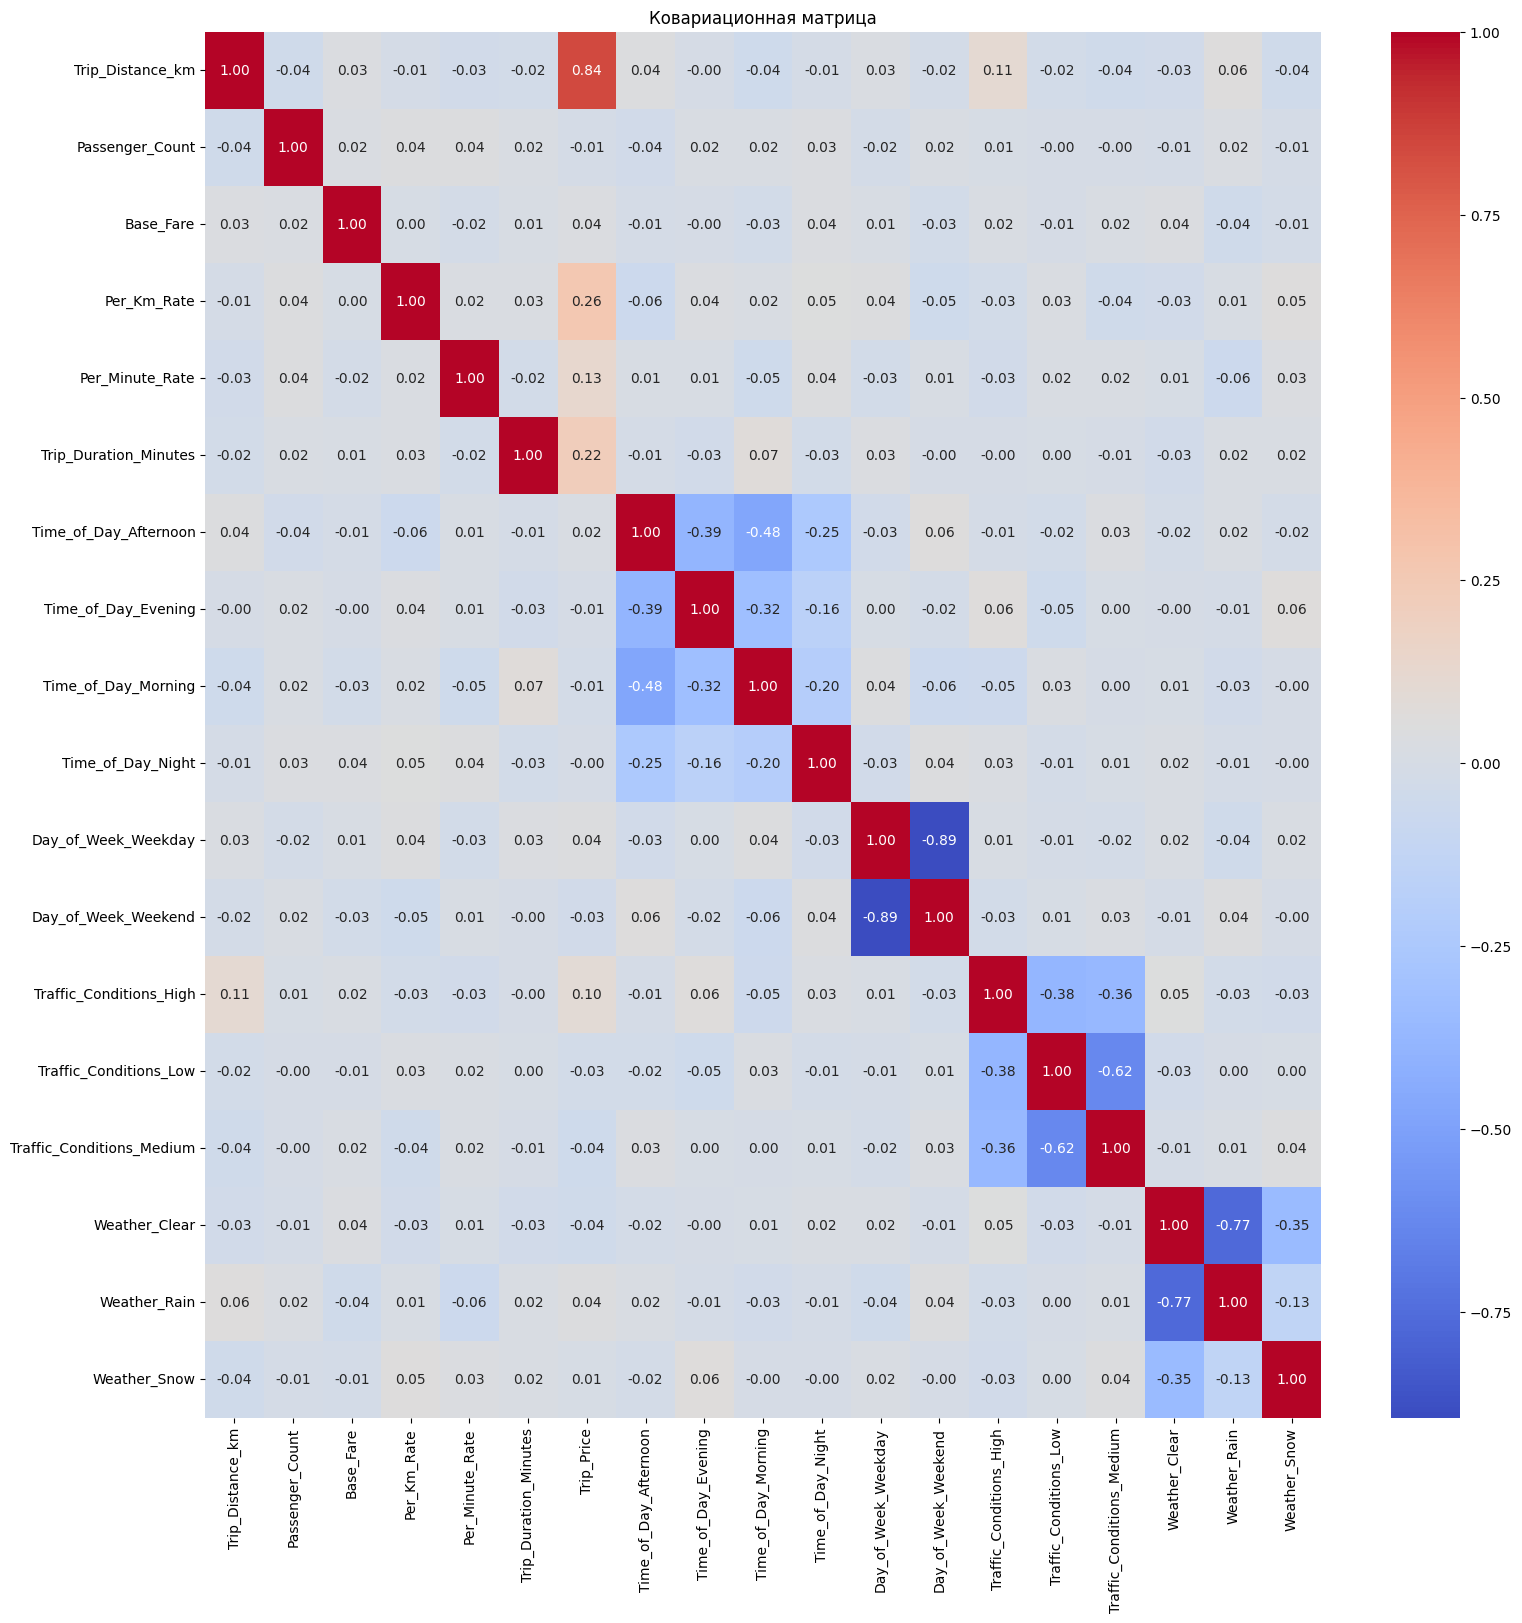

In [74]:
corr_matrix = baseline_ds.corr().drop("Trip_Price", axis=0)

plt.figure(figsize=(18, 18))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Ковариационная матрица")
plt.show()

Как видим, проблема мультиколлинеарности свойственна для категориальных признаков, таких как "Тип дня недели", "Время суток", "Условия трафика", "Погода".

Решим найденную проблему путем сведения признаков, которые были созданы через one-hot encoding к одному признаку с использованием порядкого кодирования. Такой способ также будет иметь смысл в контексте KNN алгоритма, так как между значениями теперь можно ввести понятие "расстояния".

In [75]:
optimized_ds = baseline_ds.copy()

optimized_ds["Day_of_Week"] = optimized_ds["Day_of_Week_Weekday"] + 2 * optimized_ds["Day_of_Week_Weekend"]
optimized_ds.drop(columns=["Day_of_Week_Weekday", "Day_of_Week_Weekend"], inplace=True)

optimized_ds["Time_of_Day"] = optimized_ds["Time_of_Day_Morning"] + 2 * optimized_ds["Time_of_Day_Afternoon"] + 3 * optimized_ds["Time_of_Day_Evening"] + 4 * optimized_ds["Time_of_Day_Night"]
optimized_ds.drop(columns=["Time_of_Day_Morning", "Time_of_Day_Afternoon", "Time_of_Day_Evening", "Time_of_Day_Night"], inplace=True)

optimized_ds["Traffic_Conditions"] = optimized_ds["Traffic_Conditions_Low"] + 2 * optimized_ds["Traffic_Conditions_Medium"] + 3 * optimized_ds["Traffic_Conditions_High"]
optimized_ds.drop(columns=["Traffic_Conditions_Low", "Traffic_Conditions_Medium", "Traffic_Conditions_High"], inplace=True)

optimized_ds["Weather"] = optimized_ds["Weather_Clear"] + 2 * optimized_ds["Weather_Rain"] + 3 * optimized_ds["Weather_Snow"]
optimized_ds.drop(columns=["Weather_Clear", "Weather_Rain", "Weather_Snow"], inplace=True)

optimized_ds.head()

,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price,Day_of_Week,Time_of_Day,Traffic_Conditions,Weather
0,19.35,3.0,3.56,0.80,0.32,53.82,36.2624,1,1,1,1
2,36.87,1.0,2.70,1.21,0.15,37.27,52.9032,2,3,3,1
3,30.33,4.0,3.48,0.51,0.15,116.81,36.4698,1,3,1,0
4,25.87,3.0,2.93,0.63,0.32,22.64,15.6180,1,3,3,1
5,8.64,2.0,2.55,1.71,0.48,89.33,60.2028,2,2,2,1


Проверим, улучшились ли показатели метрик после произведенных улучшений бейзлайна

In [78]:
(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds)

model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=4)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Mean Absolute Error (MAE): 14.3387
R-squared (R2): 0.8503


Как видим, показатели `MSE` немного, но уменьшились. Гипотеза была верна.

#### Нормализация и взвешивание столбцов

Также, при улучшении бейзлайна стоит учитывать особенность работый алгоритма KNN. В частности на то, что значения признаков для него являются координатами точек, на основе которых он высчитывает метрику расстояния.

Из этого можно сделать вывод, что алгоритм KNN очень чувствителен к масштабу данных. А следовательно, имеет смысл провести масштабирование данных.

Для начала проверим, свойственна ли проблема различающихся диапазонов данных для текущего датасета.

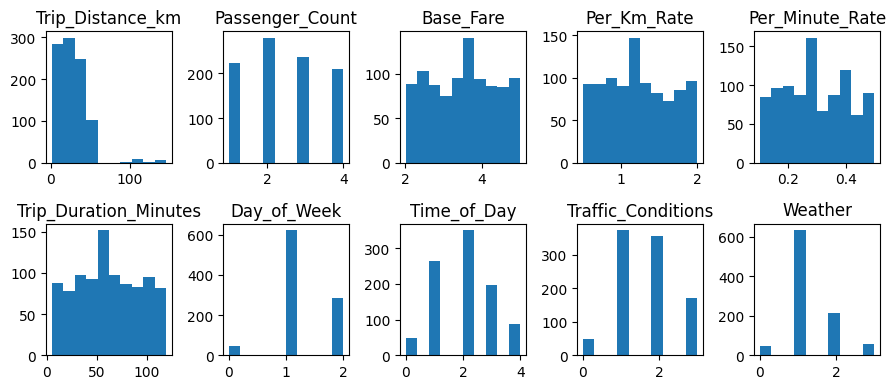

In [77]:
numerical_features = [
  "Trip_Distance_km",
  "Passenger_Count",
  "Base_Fare",
  "Per_Km_Rate",
  "Per_Minute_Rate",
  "Trip_Duration_Minutes",
  "Day_of_Week",
  "Time_of_Day",
  "Traffic_Conditions",
  "Weather",
]
n = len(numerical_features)


cols = 5
rows = math.ceil(len(numerical_features) / cols)

plt.figure(figsize=(9, rows * 2))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(rows, cols, i)
    plt.hist(optimized_ds[feature])
    plt.title(feature)
    plt.tight_layout()

plt.show()

Как видим, диапазоны значений для признаков сильно различаются. Поэтмоу имеет смысл провести нормализацию значений.

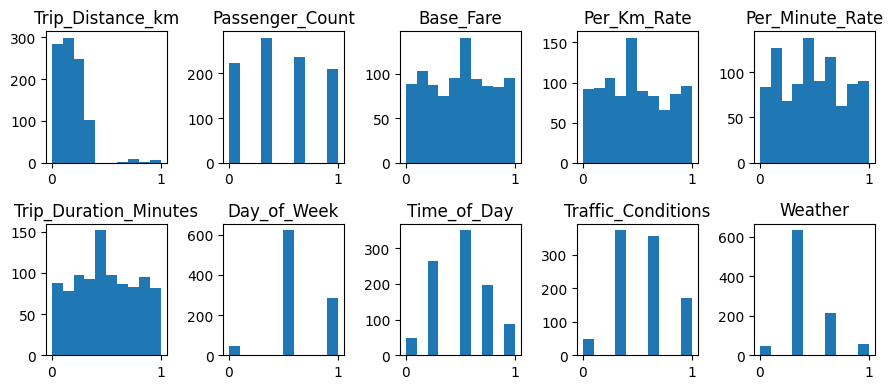

In [79]:
scaled_ds = optimized_ds.copy()
scaler = sklearn.preprocessing.MinMaxScaler()
scaled_ds[numerical_features] = scaler.fit_transform(scaled_ds[numerical_features])

cols = 5
rows = math.ceil(len(numerical_features) / cols)

plt.figure(figsize=(9, rows * 2))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(rows, cols, i)
    plt.hist(scaled_ds[feature])
    plt.title(feature)
    plt.tight_layout()

plt.show()

Проверим, улучшились ли показатели метрик после произведенных улучшений бейзлайна

In [80]:
(X_train, y_train), (X_test, y_test) = generate_train_data(scaled_ds)

model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=4)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Mean Absolute Error (MAE): 19.3130
R-squared (R2): 0.4930


Как видно, показатели метрик значительно узудшились после нормализации. Связанно это с тем, что после нормализации значения признаков стали иметь одинаковый вес, в то время как до нормализации какие-то признаки оказывались более значимыми.

Однако, данный этап необходим для следующей гипотезы.

#### Взвешивание признаков

После нормализации признаки стали иметь одинаковый вес для метрики расстояния. Однако, нам доступна возможность самим настроить веса для этих значений.

Построим новые веса для признаков из соображений корреляции: признаки, которые имеют большее значение корреляции в паре с целевой переменной, будут иметь больший вес.

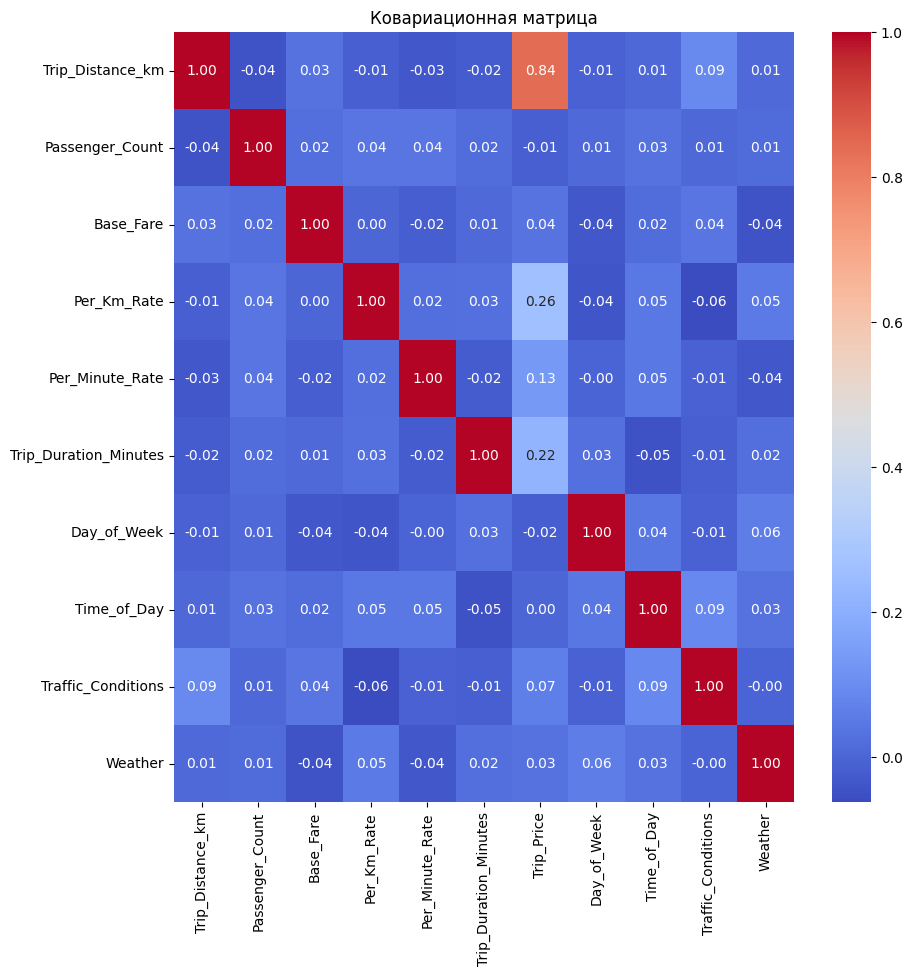

In [81]:
corr_matrix = scaled_ds.corr().drop("Trip_Price", axis=0)

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Ковариационная матрица")
plt.show()

In [82]:
correlations = corr_matrix["Trip_Price"]
k = abs(correlations).max()

weights = abs(correlations) / k
weights["Trip_Price"] = 1.0

weighted_ds = scaled_ds * weights
weighted_ds.head()

,Base_Fare,Day_of_Week,Passenger_Count,Per_Km_Rate,Per_Minute_Rate,Time_of_Day,Traffic_Conditions,Trip_Distance_km,Trip_Duration_Minutes,Trip_Price,Weather
0,0.021652,0.010213,0.010431,0.062603,0.087490,0.000260,0.026060,0.125106,0.110772,36.2624,0.011594
2,0.009639,0.020426,0.000000,0.148159,0.019884,0.000779,0.078179,0.246070,0.073213,52.9032,0.011594
3,0.020535,0.010213,0.015647,0.002087,0.019884,0.000779,0.026060,0.200915,0.253726,36.4698,0.000000
4,0.012852,0.010213,0.010431,0.027128,0.087490,0.000779,0.078179,0.170122,0.040011,15.6180,0.011594
5,0.007543,0.020426,0.005216,0.252497,0.151118,0.000519,0.052119,0.051161,0.191361,60.2028,0.011594


Проверим, улучшились ли показатели метрик после произведенных улучшений бейзлайна

In [83]:
(X_train, y_train), (X_test, y_test) = generate_train_data(weighted_ds)

model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=4)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Mean Absolute Error (MAE): 5.6710
R-squared (R2): 0.9585


Как видно, показатели метрик стали значительно лучше даже по сравнению с теми, что были до нормализации значений. А следовательно, гипотеза была верна.

### 4. Имплементация алгоритма машинного обучения

Перейдем теперь к собственной имплементации алгоритма KNN для решения задачи классификации. Решение я реализовал в виде класса `MyKNNRegressor`, который имеет интерфейс, схожий с тем, что используется в библиотеке `sklearn`. присутствуют 2 метода: `fit` - для обучения модели, `predict` - для предсказания классов для уже обученной модели.

Определение метрики расстояния я решил реализовать через функции, которые принимают на вход два массива объектов и считает попарно расстояние между ними.

In [84]:
def _broad_casted(f):
    def wrapper(ax, bx):
        return np.array([[f(a, b) for b in bx] for a in ax])
    return wrapper


@_broad_casted
def cosine_distance(a, b):
    dot_product = np.dot(a, b)
    norm_1 = np.sqrt(np.sum(a ** 2, axis=-1))
    norm_2 = np.sqrt(np.sum(b ** 2, axis=-1))
    return 1.0 - dot_product / (norm_1 * norm_2)


@_broad_casted
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2, axis=-1))


@_broad_casted
def manhattan_distance(a, b):
    return np.sum(np.abs(a - b), axis=-1)


class MyKNNRegressor:
    def __init__(self, k_neighbors=3, metric=euclidean_distance):
        self.__k = k_neighbors
        self.__distance = metric

        self.__x = None
        self.__y = None

    def fit(self, X, y):
        self.__x = np.array(X, dtype=float)
        self.__y = np.array(y, dtype=float)

    def predict(self, X):
        distances = self.__distance(self.__x, np.array(X)).T
        neighbors_ids = np.argsort(distances, axis=-1)
        neighbors_values = self.__y[neighbors_ids[:, :self.__k]]
        predicted_values = np.mean(neighbors_values, axis=-1)

        return predicted_values


#### Сранвение с бейзлайном

Обучим теперь реализованную модель на датасете, соответствущем бейзлайну. Из-за определенных ранее вспомогательных функций и схожего интерфейса класса модели основной алгоритм обучения не меняется.

In [85]:
(X_train, y_train), (X_test, y_test) = generate_train_data(baseline_ds)

model = MyKNNRegressor(k_neighbors=4)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Mean Absolute Error (MAE): 14.2187
R-squared (R2): 0.8532


Судя по показателям метрик, имплементированная модель оказалась очень схожей к модели из пункта 2. Разница в значениях метрики `MAR` очень мало и не имеет практической значимости.

#### Сравнение с улучшенным бейзлайном

In [87]:
(X_train, y_train), (X_test, y_test) = generate_train_data(weighted_ds)

model = MyKNNRegressor(k_neighbors=4)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Mean Absolute Error (MAE): 5.6710
R-squared (R2): 0.9585


Схожая ситуация обстоит и при улучшенном бейзлайне - модель оказалась очень схожей по сравнению с модель из пункта 2. Разница в значениях метриках минимальна.